In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
from kfsims.network import create_network, update_nodes_neighbors_cluster
from kfsims.common import init_trajectory
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [118]:
traj = init_trajectory()

In [119]:
NODES = 20
ITERATIONS = 30

# No fusion

In [120]:
def no_fusion_all_at_once(nm=None):
    # all at once, should be approx. same as the above
    # just a sanity check that the the step by step works
    # as expected since it's needed in diffusion
    net = create_network(NODES, iterations=ITERATIONS, noise_modifier=nm)
    rmses = []
    for node in net.nodes:
        node()
        rmses.append(node.post_rmse(traj.X))
    return round(np.mean(rmses), 3)

In [121]:
def shifted_sinus(N, sin_halves=5, shift=1):
    return shift + np.sin([np.pi * (sin_halves*i/N) for i in range(N)]) * 2

In [139]:
def rising_sinus(N, factor=2, sin_halves=5):
    return np.linspace(0, 1, N)*factor + np.sin([np.pi * (sin_halves*i/N) for i in range(N)]) * 2

Nic kromě náhodného gausovského šumu

In [140]:
# no noise
no_fusion_all_at_once(nm=None)

3.526

----

V následující variantě je šum distorted sinusovkou.

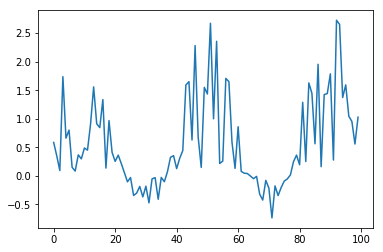

In [141]:
plt.plot(shifted_sinus(100) * np.random.rand(100))

In [142]:
no_fusion_all_at_once(nm=shifted_sinus)

8.701

-----

A tady je něco podobného ale šum se postupně zvyšuje

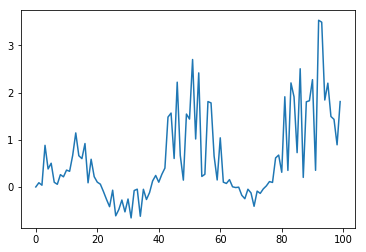

In [143]:
plt.plot(rising_sinus(100) * np.random.rand(100))

In [144]:
no_fusion_all_at_once(nm=rising_sinus)

8.563

# Simple diffusion 

In [145]:
def simple_diffusion(nm=None):
    net = create_network(NODES, 5, ITERATIONS, noise_modifier=nm)
    msrms = {node: (i for i in node.observe()) for node in net}
    rmses = []
    for i in range(traj.X.shape[1]):

        # proveď jeden KF loop pro každý node
        for node, ms in msrms.items():
            m = next(ms)
            node.single_kf(m)

        # každému nodu přiřaď průměr hyperparametrů od všech sousedů
        in_queue = set(net)
        while in_queue:
            in_queue -= update_nodes_neighbors_cluster(net, in_queue.pop())

    for node in net:
        rmses.append(node.post_rmse(traj.X))
    return round(np.mean(rmses), 3)

In [146]:
simple_diffusion(nm=None)

3.361

In [147]:
r = [simple_diffusion(nm=shifted_sinus) for i in range(10)]
np.mean(r), np.std(r)

(6.0251, 0.09194068740225946)

In [148]:
r = [simple_diffusion(nm=rising_sinus) for i in range(10)]
np.mean(r), np.std(r)

(7.855999999999999, 0.1127891838785972)